# Assignment 4: Text Classifier
### Max Davish | PPDS Spring 17

For this assignment, I'll scrape the reviews of a movies from [Roger Ebert's website](http://www.rogerebert.com/reviews) and use the text data to predict whether a review will be positive or negative.

### Step 1: Fetching the Data

In [17]:
#A useful function:
def GetHTML(URL):
    import requests
    from lxml import html 
    return html.fromstring((requests.get(URL)).text)

In [6]:
#Let's scrape some data from the main reviews page, which contains links to all the other reviews.
RE_ReviewsPage = GetHTML('http://www.rogerebert.com/reviews')
links = [link for link in  RE_ReviewsPage.xpath('//*[contains(concat( " ", @class, " " ), concat( " ", "title", " " ))]//a/@href')]
#Here are the links to other reviews pages:
for link in links:
    print(link)

/reviews/colossal-2017
/reviews/their-finest-2017
/reviews/graduation-2017
/reviews/your-name-2017
/reviews/going-in-style-2017
/reviews/win-it-all-2017
/reviews/smurfs-the-lost-village-2017
/reviews/queen-of-the-desert-2017
/reviews/mine-2017
/reviews/the-assignment-2017
/reviews/salt-and-fire-2017
/reviews/gifted-2017
/reviews/aftermath-2017
/reviews/the-ticket-2017
/reviews/all-these-sleepless-nights-2017
/reviews/the-void-2017
/reviews/five-came-back-2017
/reviews/live-cargo-2017
/reviews/ghost-in-the-shell-2017
/reviews/carrie-pilby-2017
/reviews/the-discovery-2017
/reviews/david-lynch-the-art-life-2017
/reviews/all-this-panic-2017
/reviews/god-knows-where-i-am-2017


In [7]:
#Unfortunately, the original page has only 24 reviews on it, BUT it loads more as you scroll down.
    #To access even more movies, let's try to mess around with some JSON calls we found deep in the HTML.
    #(We could do this ad infinitum, but we'll start with just the first 50 pages).

import requests
from lxml import html 
    
for page in range(0,50):
    #The reviews page contains within it a hidden API, with the following parameters.
    original_url = "http://www.rogerebert.com/reviews"
    parameters = {"great_movies":0,
        "no_stars":0,
        "order":"newest",
        "title":"spot",
        "page":page}

    new_page = requests.get(url=original_url, params=parameters)
    new_page = html.fromstring(new_page.text)
    new_links = new_page.xpath('//*[contains(concat( " ", @class, " " ), concat( " ", "title", " " ))]//a/@href')
    links += [newlink for newlink in new_links]
    
print("Now we have data on "+str(len(links))+" movie reviews.")

Now we have data on 1224 movie reviews.


In [8]:
#Now that we have the list of the links to 1000+ movie reviews, let's write functions that extract important data from those URLs
#We'll write a function that extracts the review text from a given link URL:
def ExtractReview(extension):
    root = "http://www.rogerebert.com"
    ext = str(extension)
    final_url = root + ext
    tempHTML = GetHTML(final_url)
    snippets = tempHTML.xpath('//*[contains(concat( " ", @class, " " ), concat( " ", "entry", " " ))]//div//p')
    fullreview = ""
    for snippet in snippets:
        fullreview = fullreview + snippet.text_content()
    
    return fullreview

In [9]:
#And another much shorter function to extract the rating:
def ExtractRating(extension):
    root = "http://www.rogerebert.com"
    ext = str(extension)
    final_url = root + ext
    tempHTML = GetHTML(final_url)
    stars = tempHTML.xpath("//meta[@itemprop='ratingValue']/@content")
    try:
        return float(stars[0])
    except IndexError:
        return 2
    #For some reason there is one single page in the dataset for which this XPath query encounters an error.
    #We'll arbitrarily assign that review a rating of 2.

In [10]:
#For posterity, let's also get the author and the title.
    #For our present purposes, we won't need these. But they may be useful in the future.
def ExtractAuthor(extension):
    root = "http://www.rogerebert.com"
    ext = str(extension)
    final_url = root + ext
    tempHTML = GetHTML(final_url)
    try:
        author = tempHTML.xpath('//*[contains(concat( " ", @class, " " ), concat( " ", "byline", " " ))]//a//span')[0].text_content()
        return author
    except IndexError:
        return "N/A"
    #For whatever reason, a small percentage of these pages don't follow our usual Xpath format. We'll account for those.

def ExtractTitle(extension):
    root = "http://www.rogerebert.com"
    ext = str(extension)
    final_url = root + ext
    tempHTML = GetHTML(final_url)
    title = tempHTML.xpath('//h1')[0].text_content()
    return title

In [11]:
#Now let's create a list of dictionaries that contians the name of each movie, number of stars, and review content.
    #To do this, we need to iterate through the list of links above.
    #NOTE: This takes a really long time (roughly 3 minutes depending on your processing power)!
    
data = []
for link in links:
    title = ExtractTitle(link)
    author = ExtractAuthor(link)
    review = ExtractReview(link)
    rating = ExtractRating(link)
    datapoint = {"Title" : title, "Author": author, "Rating" : rating, "Review" : review, "GoodReview" : rating>3}
    data.append(datapoint)
    
#That worked surprisingly well!

In [12]:
#Let's get a sense of what the data looks like:
import pandas
pandas.DataFrame(data)

,Author,GoodReview,Rating,Review,Title
0,Matt Zoller Seitz,True,3.5,What if Godzilla was a projection of your issu...,Colossal
1,Susan Wloszczyna,False,3.0,"When there is a global call to arms, the uplif...",Their Finest
2,Godfrey Cheshire,True,4.0,A fascinating and fastidiously complex study o...,Graduation
3,Brian Tallerico,True,3.5,“I feel like I’m always searching for somethin...,Your Name
4,Christy Lemire,False,2.5,"The original “Going in Style,” from 1979, was ...",Going in Style
5,Sheila O'Malley,False,2.5,"A desperate gambler, in a financial hole, isn'...",Win It All
6,Peter Sobczynski,False,2.0,When the brain trust at Sony Pictures Animatio...,Smurfs: The Lost Village
7,Angelica Jade Bastien,False,1.0,"Early in “Queen of the Desert,” Gertrude Bell’...",Queen of the Desert
8,Brian Tallerico,False,2.5,Fabio Guaglione & Fabio Resinaro’s “Mine” is p...,Mine
9,Peter Sobczynski,False,3.0,“The Assignment” is a film that arrives in the...,The Assignment


### Step 2/3: Specify Documents and Classes
For this project, we'll define each "document" as an entire movie review and the two classes as simply "good reviews" and "bad reviews", good reviews being reviews that scored 3.5 or 4 stars, and bad reviews being all others.

### Step 4 Tokenize/featurize the document
We'll consider each feature a new word that is an adjective, noun, verb, or adverb. We will remove stopwords.

In [13]:
#Our data is  not appropriate for the NLTK classifier.
#What we need is a LIST of TUPLES where [0] is a DICTIONARY where the features are keys and [1] is the classification.
    #To do this, we'll recycle Panos's code. 
    
import nltk
from nltk.corpus import stopwords
import random
stop_words = stopwords.words('english')

#First, write a function to featureize...
def features(document):
    sent_tokens = nltk.word_tokenize(document)
    document_words = nltk.pos_tag(sent_tokens)
    features = {}
    for word, pos in document_words:
        if (pos.startswith('NN') or pos.startswith('V') or pos.startswith('J') or pos.startswith('A')):
            features['%s/%s' % (word, pos)] = True
    return features

In [14]:
#And then loop through the data...
labeled_features = []
for datapoint in data:
    tag = datapoint["GoodReview"]
    feats = features(datapoint["Review"])
    labeled_features.append((feats, tag))

## Step 5: Run the Model, Evaluate Performance

In [18]:
#At last, we're ready to run the model!
    #And the results are not great...

trials = 10
psum = 0;
cnt = 0;
for i in range(trials):
    random.shuffle(labeled_features)
    # We will keep 500 examples for testing and the remaining ones will be training
    train_set, test_set = labeled_features[500:], labeled_features[:500]
    classifier = nltk.NaiveBayesClassifier.train(train_set)
    accuracy = nltk.classify.accuracy(classifier, test_set)
    print("Trial:", cnt, " Accuracy:", accuracy)
    psum += accuracy
    cnt += 1
    
print("Avg Accuracy: ", (psum/cnt))

Trial: 0  Accuracy: 0.228
Trial: 1  Accuracy: 0.23
Trial: 2  Accuracy: 0.206
Trial: 3  Accuracy: 0.236
Trial: 4  Accuracy: 0.218
Trial: 5  Accuracy: 0.212
Trial: 6  Accuracy: 0.222
Trial: 7  Accuracy: 0.224
Trial: 8  Accuracy: 0.21
Trial: 9  Accuracy: 0.208
Avg Accuracy:  0.21939999999999998


For some reason, the model performs _very_ poorly. In fact, it would literally be more accurate if it chose the predicted value completely at random. 

In [19]:
#Let's see which words were the most informative:
    #(It's worth noting that these features are different every time we run the model.)
classifier = nltk.NaiveBayesClassifier.train(train_set)
classifier.show_most_informative_features(30)

Most Informative Features
                lens/NNS = True             True : False  =     14.7 : 1.0
           resorting/VBG = True             True : False  =     14.2 : 1.0
             elevated/JJ = True             True : False  =     14.2 : 1.0
         intimations/NNS = True             True : False  =     14.2 : 1.0
              frames/VBZ = True             True : False  =     14.2 : 1.0
            evolving/VBG = True             True : False  =     14.2 : 1.0
               blows/NNS = True             True : False  =     14.2 : 1.0
         middle-class/NN = True             True : False  =     13.2 : 1.0
              eldest/JJS = True             True : False  =     11.6 : 1.0
           tragedies/NNS = True             True : False  =     11.6 : 1.0
            impressed/JJ = True             True : False  =     11.6 : 1.0
             extends/VBZ = True             True : False  =     11.6 : 1.0
              miners/NNS = True             True : False  =     11.6 : 1.0

Well, unfortunately our model doesn't seem highly predictive. Being that it's wrong 80% of the time, it's safe to say we did a poor job of featurization.

## Step 6: Wordcloud

In [22]:
#And now we'll make a wordcloud!

# Do not really try to understand the code below.
# It is a hack for getting the "informative features" 
# into two lists, for positive and negative terms
import math
f  = classifier._feature_probdist
mif = classifier.most_informative_features(30)
good_features = []
bad_features = []
for (w,t) in mif:
    if t != True:
        continue
    p = f[(True, w)]
    n = f[(False, w)]
    l = p.logprob(t) - n.logprob(t)
    s = l/abs(l)
    word = w.split("/")[0]
    
    # print w, math.exp(abs(l)), s
    if s>0:
        good_features.append(word)
    else:
        bad_features.append(word)
            #Note that we have no "bad features" because none of our words were predictive of bad reviews, apparently.

In [29]:
from wordcloud import WordCloud

good_wordcloud = WordCloud().generate(" ".join(good_features))
#bad_wordcloud = WordCloud().generate(" ".join(bad_features))

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 15)

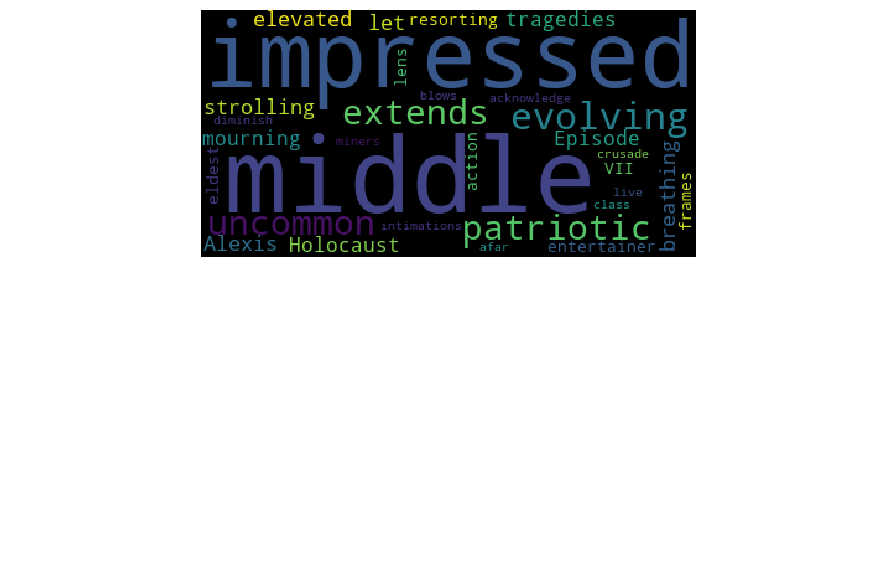

In [33]:
# Let's show it, using the "imshow" command of matplotlib
plt.figure()
# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize=(15,10))
ax1.imshow(good_wordcloud)
ax1.axis("off")
ax1.figsize=(15,10)

plt.axis("off")
plt.show()

## Deprecated Code
Below is a handful of code that ended up not being used toward the final product. I've kept it just in case I need to recycle it at some point.

In [ ]:
cleandata = [(i["GoodReview"],nltk.word_tokenize(i["Review"])) for i in data]

In [ ]:
#Let's evaluate the data a bit...
print("Total Reviews:")
print(len(cleandata))
print("Positive Reviews:")
print(len([i for i in cleandata if i[0]]))
print("Negative Reviews:")
print(len([i for i in cleandata if not i[0]]))

In [ ]:
nltk.pos_tag(cleandata[1][1])

In [ ]:
#But the data still isn't really ready for the model...
    #We need to remove stopwords, prepositions, articles, etc.
    #And then we need to featurize the data so NLTK can interpret it.
    #The goal is to have a list of tuples, each of which has a feature and a boolean value. 
    
import nltk
from nltk.corpus import stopwords
import random
stop_words = stopwords.words('english')


cleanerdata = []
for datapoint in cleandata:
    tag = datapoint[0]                     #True or false - good review or bad review
    tokens = nltk.pos_tag(datapoint[1])    #A list of tuples containing the words and the parts of speech
    newdatapoints = []
    for token in tokens:
        pos = (token)[1]                   #The part of speech for each given word
        if (pos.startswith('NN') or pos.startswith('V') or pos.startswith('J') or pos.startswith('A')) and token not in stop_words:
            #We only want adjectives, verbs, adverbs, and nouns that also aren't stopwords.
            foo = tuple((tag, token[0]))
            #print(type(foo)) #Yup it's definitely a tuple!
            newdatapoints.append(foo)
            
    for newdatapoint in newdatapoints:
        cleanerdata.append(newdatapoint)